In [15]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt


In [16]:
%cuda_context_handler gpu_ctx

In [17]:
gpu_stream = cuda.Stream()

In [18]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

In [19]:
grid_args = initGridSpecs(10)

coarse_grid_args = initGridSpecs(9)

In [20]:
model_error_args = {
    "nx": grid_args["nx"],
    "ny": grid_args["ny"],
    "dx": grid_args["dx"],
    "dy": grid_args["dy"],
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

model_error_args_coarse = {
    "nx": coarse_grid_args["nx"],
    "ny": coarse_grid_args["ny"],
    "dx": coarse_grid_args["dx"],
    "dy": coarse_grid_args["dy"],
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }


sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

def make_init_fields(args):
    dataShape = (args["ny"] + 4, args["nx"] + 4)
    dataShapeH = (args["ny"] + 5, args["nx"] + 5)

    eta = np.zeros(dataShape, dtype=np.float32)
    hu  = np.zeros(dataShape, dtype=np.float32)
    hv  = np.zeros(dataShape, dtype=np.float32)
    Hi = np.ones(dataShapeH, dtype=np.float32)*60

    return {"eta": eta, "hu": hu, "hv": hv, "Hi": Hi}

def imshow(data):
    fig = plt.figure()
    plt.imshow(data, origin="lower")
    plt.colorbar()

def imshowDataArgs(data_args):
    imshow3(data_args["eta"], data_args["hu"], data_args["hv"])

def imshowSim(sim):
    eta, hu, hv = sim.download(interior_domain_only=False)
    imshow3(eta, hu, hv)

def imshow3(eta, hu, hv):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    eta_im = axs[0].imshow(eta[2:-2, 2:-2], origin="lower")
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])

    hu_im = axs[1].imshow(hu[2:-2, 2:-2], origin="lower")
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    hv_im = axs[2].imshow(hv[2:-2, 2:-2], origin="lower")
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    


In [21]:
reload(ModelErrorKL)

mekl = ModelErrorKL.ModelErrorKL(**model_error_args, include_sin=True) #, basis_x_end=1, basis_y_end=1)

In [25]:
data_args = make_init_fields(model_error_args)
#mekl.perturbEtaCPU(data_args["eta"])


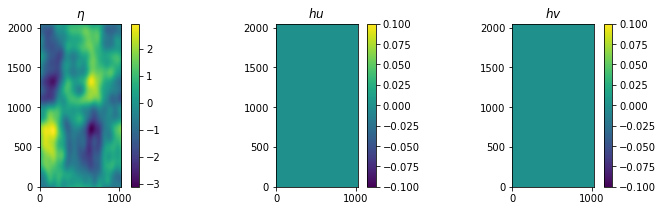

In [26]:
mekl.perturbEtaCPU(data_args["eta"])
imshowDataArgs(data_args)

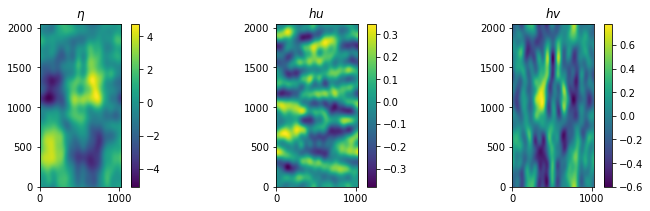

In [27]:
mekl.perturbOceanStateCPU(**data_args, **sample_args)
imshowDataArgs(data_args)

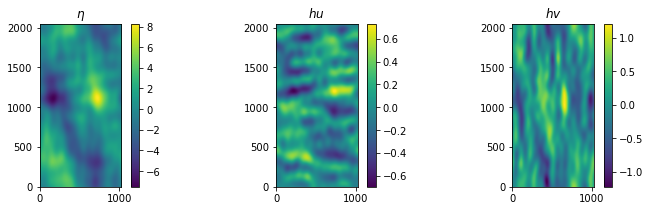

In [28]:
mekl.perturbOceanStateCPU(**data_args, **sample_args)
imshowDataArgs(data_args)

### Test perturbing two ocean states with different resolution 

In [77]:
fine_data_args = make_init_fields(model_error_args)
unperturbed = copy.deepcopy(fine_data_args)

basis_x_start = 2
basis_x_end = 7
basis_y_start = 1
basis_y_end = 6

kl_decay = 2.5
kl_scaling = 0.15

fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args, include_sin=False, 
                                      basis_x_start=basis_x_start, basis_x_end=basis_x_end, basis_y_start=basis_y_start, basis_y_end=basis_y_end,
                                      kl_decay=kl_decay, kl_scaling=kl_scaling) #, basis_x_end=1, basis_y_end=1)

coarse_mekl = ModelErrorKL.ModelErrorKL(**model_error_args_coarse, include_sin=False, 
                                        basis_x_start=basis_x_start, basis_x_end=basis_x_end, basis_y_start=basis_y_start, basis_y_end=basis_y_end,
                                        kl_decay=kl_decay, kl_scaling=kl_scaling) #, basis_x_end=1, basis_y_end=1)

In [78]:
roll_coarse = {
    "roll_x_sin": np.random.rand(), #5,
    "roll_y_sin": np.random.rand(), #34,
    "roll_x_cos": np.random.rand(), #40,
    "roll_y_cos": np.random.rand(), #16,
}

roll_fine = {
    "roll_x_sin": roll_coarse["roll_x_sin"], #50,
    "roll_y_sin": roll_coarse["roll_y_sin"], #340,
    "roll_x_cos": roll_coarse["roll_x_cos"], #480,
    "roll_y_cos": roll_coarse["roll_y_cos"], #160,
}

In [79]:
fine_mekl.perturbOceanStateCPU(**fine_data_args, **sample_args, **roll_fine)


In [80]:
coarse_data_args = {}

coarse_data_args["eta"] = np.pad(block_reduce(unperturbed["eta"][2:-2,2:-2], block_size=(2,2), func=np.mean), ((2,2),(2,2)))
coarse_data_args["hu"] = np.pad(block_reduce(unperturbed["hu"][2:-2,2:-2], block_size=(2,2), func=np.mean), ((2,2),(2,2)))
coarse_data_args["hv"] = np.pad(block_reduce(unperturbed["hv"][2:-2,2:-2], block_size=(2,2), func=np.mean), ((2,2),(2,2)))

coarse_data_args["Hi"] = np.ones((model_error_args_coarse["ny"]+3,model_error_args_coarse["nx"]+3) , dtype=np.float32)*60

In [81]:
coarse_mekl.perturbOceanStateCPU(**coarse_data_args, **sample_args, **roll_coarse,
                                 random_numbers=fine_mekl.random_numbers_host)

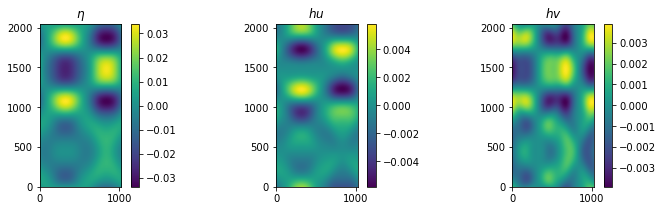

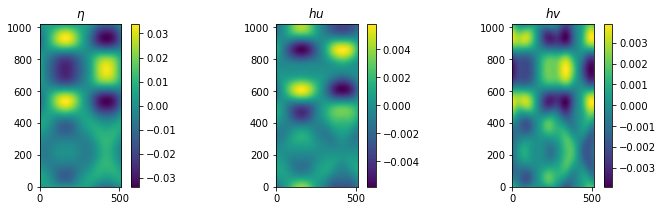

In [82]:
imshowDataArgs(fine_data_args)
imshowDataArgs(coarse_data_args)

In [76]:
fine_data_args["eta"].shape, coarse_data_args["eta"].shape

((2052, 1028), (1028, 516))

# Start sim with one of these states 

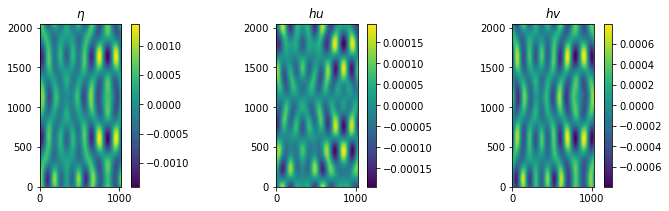

In [63]:
def make_sim(me_args, init_fields = None):
    if init_fields is None:
        init_fields = make_init_fields(me_args)

    sim_args = {
        "gpu_ctx" : gpu_ctx,
        "nx" : me_args["nx"],
        "ny" : me_args["ny"],
        "dx" : me_args["dx"],
        "dy" : me_args["dy"],
        "f"  : sample_args["f"],
        "g"  : sample_args["g"],
        "r"  : 0,
        "dt" : 0,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2),
        "eta0" : init_fields["eta"],
        "hu0"  : init_fields["hu"],
        "hv0"  : init_fields["hv"],
        "H"    : init_fields["Hi"],
    }

    return CDKLM16.CDKLM16(**sim_args)
sim = make_sim(model_error_args, fine_data_args)


imshowSim(sim)


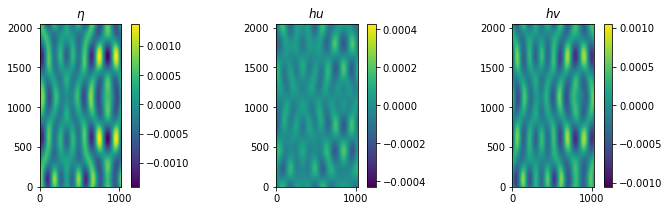

In [64]:
sim.step(10000)
imshowSim(sim)

# GPU 

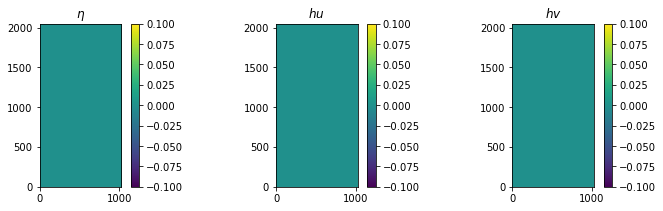

In [65]:
sim = make_sim(model_error_args)
imshowSim(sim)

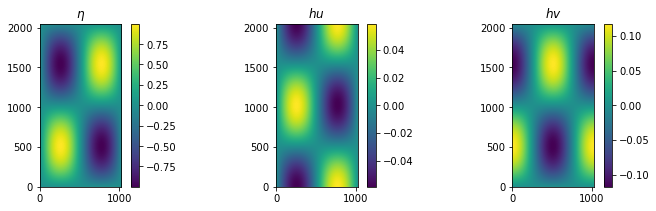

In [66]:
reload(ModelErrorKL)
fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args) # include_sin=False) #, basis_x_end=1, basis_y_end=1)
fine_mekl.random_numbers_host *= 0
fine_mekl.random_numbers_host[0,0] = 1
fine_mekl.perturbSim(sim, random_numbers=fine_mekl.random_numbers_host, roll_x_sin=0, roll_x_cos=0, roll_y_sin=0, roll_y_cos=0)
imshowSim(sim)

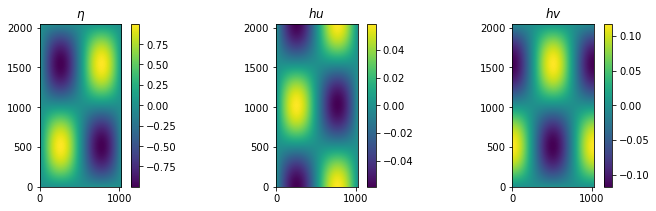

In [68]:
for i in range(1000):
    sim.step(10)
imshowSim(sim)

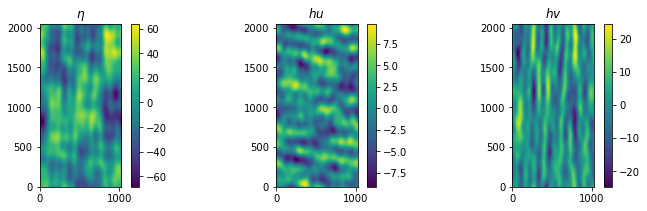

In [69]:
for i in range(1000):
    fine_mekl.perturbSim(sim)
imshowSim(sim)

# Check that we can perturb the ocean state similarly to how we perturb eta

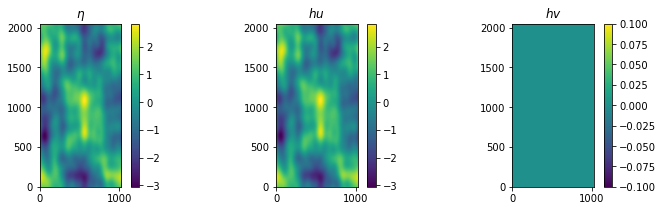

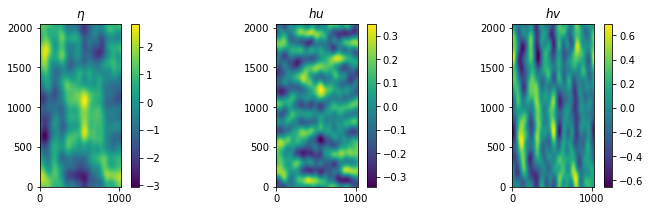

In [83]:
reload(ModelErrorKL)

sim1 = make_sim(model_error_args)
sim2 = make_sim(model_error_args)

roll_x_sin=np.random.rand()
roll_x_cos=np.random.rand()
roll_y_sin=np.random.rand()
roll_y_cos=np.random.rand()


fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args) 

fine_mekl.perturbEtaSim(sim1, roll_x_sin=roll_x_sin, roll_x_cos=roll_x_cos, roll_y_sin=roll_y_sin, roll_y_cos=roll_y_cos)
fine_mekl.perturbSim(sim2, update_random_field=False, roll_x_sin=roll_x_sin, roll_x_cos=roll_x_cos, roll_y_sin=roll_y_sin, roll_y_cos=roll_y_cos)

eta1, hu1, hv1 = sim1.download()
eta2, hu2, hv2 = sim2.download()

imshow3(eta1, eta2, eta1-eta2)
imshowSim(sim2)

# fig = plt.figure(figsize=(14,10))
# plt.imshow(hu2[200:-200,300:-300], origin='lower')
# plt.colorbar()


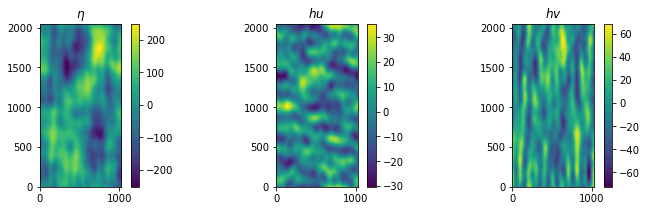

In [86]:
for i in range(1000):
    fine_mekl.perturbSim(sim2)
imshowSim(sim2)

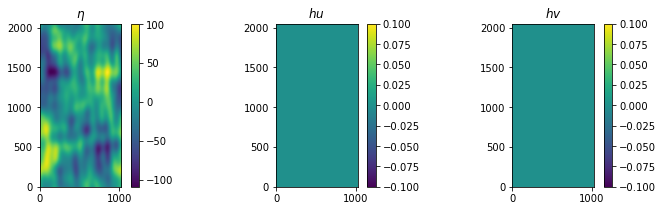

In [87]:
for i in range(1000):
    fine_mekl.perturbEtaSim(sim1)
imshowSim(sim1)



# Test running a perturbed state 
Is the perturbed state balanced?

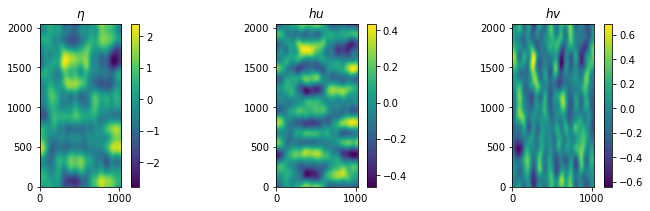

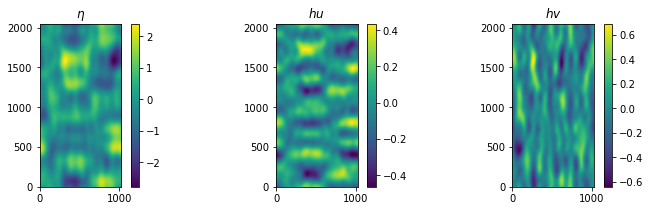

In [88]:
sim = make_sim(model_error_args)
fine_mekl.perturbSim(sim)
imshowSim(sim)
sim.step(10000)
imshowSim(sim)

# Test API for perturbing similar as other sim/model error

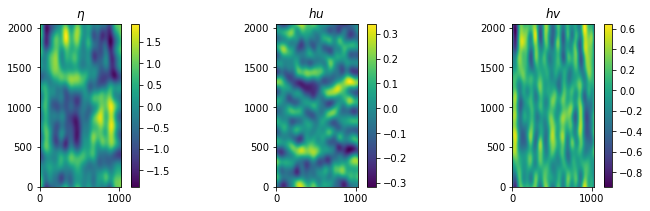

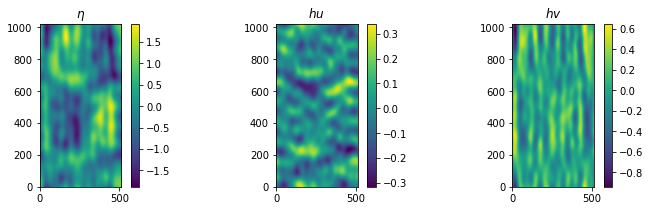

In [90]:
reload(ModelErrorKL)

sim_fine   = make_sim(model_error_args)
sim_coarse = make_sim(model_error_args_coarse)

fine_mekl   = ModelErrorKL.ModelErrorKL(**model_error_args) 
coarse_mekl = ModelErrorKL.ModelErrorKL(**model_error_args_coarse) 

fine_mekl.perturbSim(sim_fine)
coarse_mekl.perturbSimSimilarAs(sim_coarse, modelError=fine_mekl)

imshowSim(sim_fine)
imshowSim(sim_coarse)

